# **DESIGN OPTIMIZATION EXAMPLES**
By Ahmad Fariz

Reuse is permitted for educational purpose only

Credit to CAMY LABOTECH

# Nothing

In [1]:
# importing required libraries
import numpy as np
import matplotlib.pyplot as plt

##Run Optimization

In [2]:
# generate data
true_slope = 10.889
true_intercept = 3.456
X = np.arange(-10.0, 11.0, step=1)
Y_determinstic = X*X
Y_stochastic = np.random.normal(loc=X**2, scale=3)

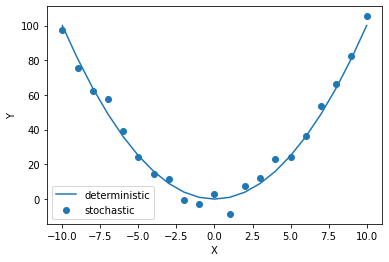

In [3]:
plt.figure()
plt.plot(X, Y_determinstic, label='deterministic')
plt.scatter(X, Y_stochastic, label='stochastic')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Optimization using Genetic Algorithm

In [4]:
!pip install control

In [5]:
# importing required libraries
from collections import namedtuple
from random import choices, randint, randrange, random
from typing import List, Tuple, Callable
from functools import partial
import control
from control.matlab import lsim
import matplotlib.pyplot as plt
import numpy as np
import time

## Genetic Algorithm
Prepare required functions

In [6]:
class GeneticAlgorithm:
  def __init__(self, population_size: int, 
               generation: int, constraint: int, 
               mutation_stdev: int, dimension: int, 
               init_value: list, system: control.TransferFunction):
    self.population_size = population_size
    self.generation_limit = generation
    self.fitness_limit = constraint
    self.mutation_stdev = mutation_stdev
    self.genome_length = dimension
    self.genome_probability = 1
    self.genome_init = init_value
    self.system = system

  def generate_genome(self):
    genome = []
    for i in range(self.genome_length):
      # genome.append(self.genome_init[i])
      genome.append(np.random.normal(loc=self.genome_init[i], scale=self.genome_probability))
    return genome

  def generate_population(self):
    if len(self.genome_init) != self.genome_length:
      raise("genome length and length of init_genome_value list must be the same")
    return [self.generate_genome() for _ in range(self.population_size)]

  def selection_pair(self, population):
    return choices(
        population=population,
        weights=[random() for _ in population],
        k=2
    )

  def single_point_crossover(self, a, b):
    if len(a) != len(b):
      raise ValueError("a and b must be of the same length")

    length = len(a)
    if length < 2:
      return a, b

    p = randint(1, length-1)
    return a[0:p] + b[p:], b[0:p] + a[p:]

  def mutation(self, genome, num: int = 1):
    if len(genome) == 0:
      return genome
    for _ in range(num):
      index = randrange(len(genome))
      genome[index] = np.random.normal(loc=genome[index], scale=self.mutation_stdev)
    return genome

  def run(self, objective_func):
    start = time.time()
    
    population = self.generate_population()
    fitness_all_gen = []

    for generation in range(self.generation_limit):
      population = sorted(
          population,
          key=lambda genome: objective_func(genome, self.system),
          reverse=False
      )

      fitness_value = objective_func(population[0], self.system)
      fitness_all_gen.append(fitness_value)

      next_generation = population[0:2] # keep top solution for the next generation

      for j in range(int(len(population)/2) - 1):
        parents = self.selection_pair(population)
        offspring_a, offspring_b = self.single_point_crossover(parents[0], parents[1]) # get child solution from selected parents
        offspring_a = self.mutation(offspring_a)  # generate variety of the solution
        offspring_b = self.mutation(offspring_b)

        next_generation += [offspring_a, offspring_b] # add variety of solution to the next generation

      population = next_generation
    
    population = sorted(
          population,
          key=lambda genome: objective_func(genome, self.system),
          reverse=False
      )
    
    end = time.time()
    duration = end-start
      
    return population[0], generation, fitness_value, fitness_all_gen, duration

## Run optimization

In [7]:
def plot_response(t, y, t_settling):
  plt.figure()
  plt.grid(True)
  plt.xlabel('Time [s]')
  plt.ylabel('State')
  # plt.xlim(left=0, right=None)
  plt.plot([0, t[-1]], [0.98, 0.98], 'k--')
  plt.plot([0, t[-1]], [1.02, 1.02], 'k--')

  plt.plot(t, y, 'b', label='Response')
  plt.plot([t_settling, t_settling], [0, 1.4], 'b--', label='Settling time')
  plt.legend()

In [8]:
def plot_input(t, u):
    plt.figure()
    plt.grid(True)
    plt.xlabel('Time [s]')
    plt.ylabel('Input')
    # plt.xlim(left=0, right=None)
    plt.plot(t, u, 'r', label='input')
    plt.legend()

In [9]:
def pid_step_simulation(system, k_p, k_i, k_d):
  if np.isnan(k_p) or np.isnan(k_i) or np.isnan(k_d):
    print("Skip this simulation because NaN gain exist")
    return False

  s = control.TransferFunction.s
  
  try:
    info = control.step_info(system, T=t_simulation)
    t_settling = info.get("SettlingTime", np.inf)
  except IndexError:
    print("no step info")
    t_settling = np.inf

  t, y = control.step_response(system, T=t_simulation, return_x=False)
  
  plot_response(t, y, t_settling)

  if k_p != 0 or k_i != 0 or k_d != 0:
    K = k_p + k_i/s + k_d*s/(1+0.001*s)
    series = control.series(K, system)
    closed_loop = control.feedback(series)

    try:
      info_controlled = control.step_info(closed_loop, T=t_simulation)
      t_settling_controlled = info_controlled.get("SettlingTime", np.inf)
    except IndexError:
      print("no step info")
      t_settling_controlled = np.inf

    t_controlled, y_controlled = control.step_response(closed_loop, T=t_simulation, return_x=False)
    sim_result = lsim(sys=K, U=1-y_controlled, T=t_controlled)
    u_control = sim_result[0]

    plot_response(t_controlled, y_controlled, t_settling_controlled)   
    plot_input(t_controlled, u_control)
    
    print("")
    print(f"Control Effort={np.sum(u_control**2)}")
    print("")

  plt.legend()

In [13]:
class PidOptimizer:
  def __init__(self, method):
    self.best_duration = np.inf
    self.best_pid = [np.nan, np.nan, np.nan]
    self.best_objective_value = np.inf
    self.best_objective_all_gen = []
    self.optimization_method = method

  def objective_function(self, pid, system):
    s = control.TransferFunction.s
    K = pid[0] + pid[1]/s + pid[2]*s/(1+0.001*s)

    loop = control.series(K, system)
    closed_loop = control.feedback(loop)

    try:
      # # Minimum Settling Time 
      # info_controlled = control.step_info(closed_loop, T=t_simulation)
      # t_settling_controlled = info_controlled["SettlingTime"]

      # if np.isnan(t_settling_controlled):
      #   t_settling_controlled = np.inf
          
      # J = t_settling_controlled
      
      # Minimum State Error, Minimum Control Effort
      t_controlled, y_controlled = control.step_response(closed_loop, T=t_simulation, return_x=False)
      sim_result = lsim(sys=K, U=1-y_controlled, T=t_controlled)
      u_control = sim_result[0]

      Q = 1
      R = 0.001
      state_error = Q*((1-y_controlled)**2)
      control_effort = R*(u_control**2)
      J = np.sum(state_error + control_effort)

    except IndexError:
      J = np.inf
    return J

  def run(self):
    pid, generations, objective_value, objective_all_gen, duration = self.optimization_method.run(self.objective_function)

    print(f"#run={id} | pid={list(map(lambda x: float(format(x, '.5g')), pid))} | #generations={generations} | objective={float(format(objective_value, '.5g'))} | duration={float(format(duration, '.5g'))}s")

    self.check_best(id, objective_value, objective_all_gen, duration, pid)
      
    self.plot_objective_value()

    self.print_best()

    return self.best_pid, self.best_objective_value

  def check_best(self, id, objective_value, objective_all_gen, duration, pid):
    if not np.isinf(objective_value) and objective_value < self.best_objective_value:
      self.best_objective_value = objective_value
      self.best_objective_all_gen = objective_all_gen
      self.best_duration = duration
      self.best_pid = pid

  def plot_objective_value(self):
    plt.figure()
    plt.plot(list(range(1, len(self.best_objective_all_gen)+1)), self.best_objective_all_gen)
    plt.xlabel("Generation")
    plt.ylabel("Objective Value")
    plt.grid(True)

  def print_best(self):
    # communicate result
    print("")
    print("====================Optimization Result=================================")
    print("")
    print(f"Best PID: Kp={format(self.best_pid[0], '.5g')}, Ki={format(self.best_pid[1], '.5g')}, Kd={format(self.best_pid[2], '.5g')}")
    print(f"Objective value: {format(self.best_objective_value, '.5g')}")
    print("")
    print("==========================================================================")
    print("")

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


#run=<built-in function id> | pid=[1.4144, 1.2105, -0.016319] | #generations=39 | objective=10.19 | duration=9.3653s

====================Optimization Result=================================

Best PID: Kp=1.4144, Ki=1.2105, Kd=-0.016319
Objective value: 10.19



Control Effort=609.4489954595977



/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


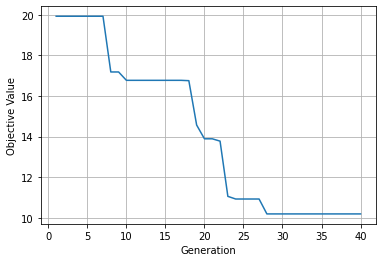

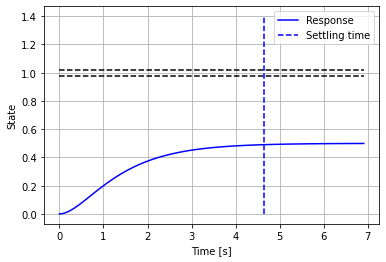

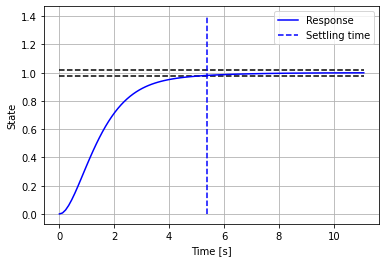

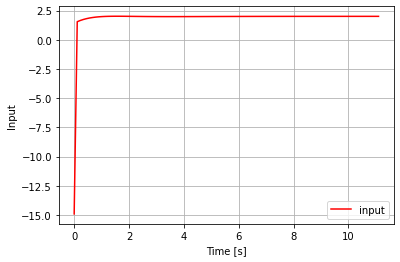

In [14]:
t_simulation = None

s = control.TransferFunction.s
unknown_system = 1/((s+2)*(s+1))
#unknown_system = 1 / ((s-0.05)*(s+3))

# design variables
k_p = 0.1
k_i = 0.1
k_d = 0.1

ga = GeneticAlgorithm(population_size=10, generation=40, 
                      dimension=3, init_value=[k_p, k_i, k_d], 
                      system=unknown_system, constraint=np.inf,
                      mutation_stdev=0.5)
optimizer = PidOptimizer(ga)

results = optimizer.run()

pid = results[0]
pid_step_simulation(unknown_system, k_p=pid[0], k_i=pid[1], k_d=pid[2])